In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten,Input
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5005)


In [2]:
batch_size = 8
nb_classes = 9
#image_size=(218,303)
#input_shape=(3,218,303)
#image_size=(128,128)
#input_shape=(3,128,128)
image_size=(224,224)
input_shape=(3,224,224)
classes=["chicken","ostrich",'bluebird','finch','frog','salemander','cobra','bird','flamingo']

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '../data/cs231n_project/data/train',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_directory(
        '../data/cs231n_project/data/val',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 10177 images belonging to 9 classes.
Found 1328 images belonging to 9 classes.


In [4]:
nb_epoch = 12
nb_filters=32
kernel_size=(3,3)
pool_size=(2,2)

In [5]:
resnet_model = ResNet50(weights='imagenet',include_top=False)
for layer in resnet_model.layers:
    layer.trainable=False
img=Input(shape=(3,224,224))
x=resnet_model(img)
x=Flatten()(x)
x=Dense(128)(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)
x=Dense(nb_classes)(x)
x=Activation('softmax')(x)
model=Model(input=img,output=x)

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [7]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
resnet50 (Model)                 multiple              23587712    input_2[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 2048)          0           resnet50[1][0]                   
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 128)           262272      flatten_1[0][0]                  
___________________________________________________________________________________________

In [8]:
hist=model.fit_generator(train_generator,samples_per_epoch=1000, 
                         validation_data=test_generator,nb_val_samples=100,
                         nb_epoch=nb_epoch,verbose=1)
score = model.evaluate_generator(test_generator, val_samples=10)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
1000/1000 [==============================] - 24s - loss: 1.4872 - acc: 0.5090 - val_loss: 2.3509 - val_acc: 0.1058
Epoch 2/12
1000/1000 [==============================] - 24s - loss: 0.7608 - acc: 0.7670 - val_loss: 2.3687 - val_acc: 0.1538
Epoch 3/12
1000/1000 [==============================] - 24s - loss: 0.6312 - acc: 0.8070 - val_loss: 2.1680 - val_acc: 0.2212
Epoch 4/12
1000/1000 [==============================] - 24s - loss: 0.4729 - acc: 0.8540 - val_loss: 2.6040 - val_acc: 0.1923
Epoch 5/12
1000/1000 [==============================] - 24s - loss: 0.4718 - acc: 0.8470 - val_loss: 1.6061 - val_acc: 0.5096
Epoch 6/12
1000/1000 [==============================] - 24s - loss: 0.4146 - acc: 0.8780 - val_loss: 1.2612 - val_acc: 0.6250
Epoch 7/12
1000/1000 [==============================] - 24s - loss: 0.4277 - acc: 0.8660 - val_loss: 0.6021 - val_acc: 0.8077
Epoch 8/12
1000/1000 [==============================] - 24s - loss: 0.4465 - acc: 0.8610 - val_loss: 0.1930 - val_acc:

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


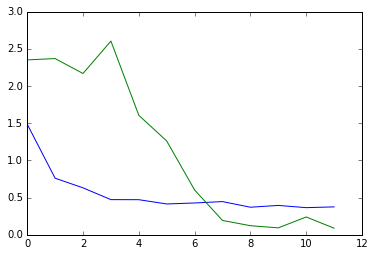

Max Train acc: 0.887
Max Val   acc: 0.971153846154


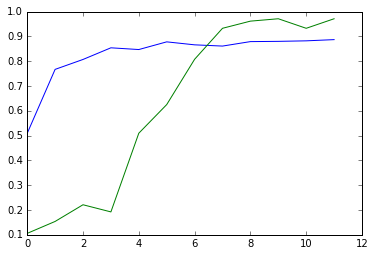

In [9]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()
print ("Max Train acc:",np.max(hist.history['acc']))
print ("Max Val   acc:",np.max(hist.history['val_acc']))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.show()

In [10]:
score = model.evaluate_generator(test_generator, val_samples=100)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.227087415826
Test accuracy: 0.932692307692
